# Setup Google Drive Environment

In [0]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
file1 = drive.CreateFile({'id':'1wmgfD6kvQ5TkfxNDtPq-tvBJ-uJ2Q3Ak'})
file1.GetContentFile('synopses_list_imdb.txt')  
file2 = drive.CreateFile({'id':'1UwMBoK9hBsad4vx4-6kvOMv8O1U9Ejnu'})
file2.GetContentFile('synopses_list_wiki.txt')  
file3 = drive.CreateFile({'id':'1SfszUP63CRq87ezneov23A-i7Y98_mYu'})
file3.GetContentFile('title_list.txt')  

# Load Data

In [44]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import nltk
import re
import os

from sklearn import decomposition
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
#import three lists: titles and wikipedia synopses
titles = open('title_list.txt').read().split('\n')
titles = titles[:100] #ensures that only the first 100 are read in

#The wiki synopses and imdb synopses of each movie is seperated by the keywords "BREAKS HERE". 
#Each synoposes may consist of multiple paragraphs.
synopses_wiki = open('synopses_list_wiki.txt').read().split('\n BREAKS HERE')
synopses_wiki = synopses_wiki[:100]

synopses_imdb = open('synopses_list_imdb.txt').read().split('\n BREAKS HERE')
synopses_imdb = synopses_imdb[:100]

#Combine imdb and wiki to get full synoposes for the top 100 movies. 
synopses = []
for i in range(len(synopses_wiki)):
    item = synopses_wiki[i] + synopses_imdb[i]
    synopses.append(item)
    
#Because these synopses have already been ordered in popularity order, 
#we just need to generate a list of ordered numbers for future usage.
ranks = range(len(titles))

# Tokenizing and Stemming

In [46]:
# Use nltk's English stopwords.
stopwords = nltk.corpus.stopwords.words('english')

print ("We use " + str(len(stopwords)) + " stop-words from nltk library.")
print (stopwords[:10])

We use 179 stop-words from nltk library.
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


In [0]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

def tokenization_and_stemming(text):
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if word not in stopwords]
#     tokens=[]
#     for sent in nltk.sent_tokenize(text):
#         for word in nltk.word_tokenize(sent):
#             if word not in stopwords:
#                 tokens.append(word);   
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

def tokenization(text):
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if word not in stopwords]
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [48]:
# testing

tokenization_and_stemming("she looked at her father's arm.")

['look', 'father', "'s", 'arm']

In [0]:
docs_stemmed = []
docs_tokenized = []
for i in synopses:
    tokenized_and_stemmed_results = tokenization_and_stemming(i)
    docs_stemmed.extend(tokenized_and_stemmed_results)
    
    tokenized_results = tokenization(i)
    docs_tokenized.extend(tokenized_results)

In [50]:
vocab_frame_dict = {docs_stemmed[x]:docs_tokenized[x] for x in range(len(docs_stemmed))}

#testing

print (vocab_frame_dict)

{'plot': 'plot', 'edit': 'edit', 'on': 'on', 'day': 'days', 'daughter': 'daughter', "'s": "'s", 'wed': 'wedding', 'vito': 'vito', 'corleon': 'corleone', 'hear': 'hears', 'request': 'requesting', 'role': 'role', 'godfath': 'godfather', 'don': 'don', 'new': 'new', 'york': 'york', 'crime': 'crime', 'famili': 'family', 'youngest': 'youngest', 'son': 'son', 'michael': 'michael', 'marin': 'marine', 'corp': 'corps', 'uniform': 'uniform', 'introduc': 'introduces', 'girlfriend': 'girlfriend', 'kay': 'kay', 'adam': 'adam', 'sprawl': 'sprawling', 'recept': 'receptive', 'godson': 'godson', 'johnni': 'johnny', 'fontan': 'fontane', 'popular': 'popular', 'singer': 'singer', 'plead': 'pleads', 'help': 'helping', 'secur': 'security', 'covet': 'coveted', 'movi': 'movie', 'dispatch': 'dispatches', 'consiglier': 'consigliere', 'tom': 'tom', 'hagen': 'hagen', 'los': 'los', 'angel': 'angeles', 'influenc': 'influence', 'abras': 'abrasive', 'studio': 'studio', 'head': 'head', 'jack': 'jack', 'woltz': 'woltz',

# TF-IDF

In [51]:
#define vectorizer parameters
tfidf_model = TfidfVectorizer(max_df=0.8, max_features=2000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenization_and_stemming, ngram_range=(1,1))

tfidf_matrix = tfidf_model.fit_transform(synopses) #fit the vectorizer to synopses

print ("In total, there are " + str(tfidf_matrix.shape[0]) + \
      " synoposes and " + str(tfidf_matrix.shape[1]) + " terms.")

In total, there are 100 synoposes and 538 terms.


In [52]:
tfidf_model.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.float64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 0.8,
 'max_features': 2000,
 'min_df': 0.2,
 'ngram_range': (1, 1),
 'norm': 'l2',
 'preprocessor': None,
 'smooth_idf': True,
 'stop_words': 'english',
 'strip_accents': None,
 'sublinear_tf': False,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': <function __main__.tokenization_and_stemming>,
 'use_idf': True,
 'vocabulary': None}

In [53]:
tf_selected_words = tfidf_model.get_feature_names()
tf_selected_words

["'d",
 'abandon',
 'abl',
 'accept',
 'accid',
 'accompani',
 'accus',
 'act',
 'action',
 'actual',
 'admit',
 'afterward',
 'ago',
 'agre',
 'air',
 'aliv',
 'allow',
 'alon',
 'alreadi',
 'alway',
 'american',
 'angri',
 'angrili',
 'announc',
 'anoth',
 'answer',
 'anyon',
 'anyth',
 'apart',
 'appar',
 'appear',
 'approach',
 'area',
 'argu',
 'arm',
 'armi',
 'arrang',
 'arrest',
 'arriv',
 'ask',
 'assign',
 'assist',
 'assum',
 'attack',
 'attempt',
 'attend',
 'attent',
 'attract',
 'audienc',
 'avoid',
 'away',
 'bad',
 'bar',
 'bare',
 'battl',
 'beat',
 'becom',
 'bed',
 'beg',
 'believ',
 'best',
 'better',
 'big',
 'black',
 'blow',
 'board',
 'bodi',
 'book',
 'boss',
 'boy',
 'break',
 'brief',
 'bring',
 'broken',
 'brother',
 'build',
 'burn',
 'busi',
 'buy',
 'ca',
 'camp',
 'captain',
 'captur',
 'car',
 'care',
 'career',
 'carri',
 'case',
 'catch',
 'caus',
 'chanc',
 'chang',
 'charg',
 'chase',
 'child',
 'children',
 'citi',
 'claim',
 'clear',
 'climb',
 'c

In [54]:
tfidf_matrix

<100x538 sparse matrix of type '<class 'numpy.float64'>'
	with 19003 stored elements in Compressed Sparse Row format>

# K-means clustering

In [0]:
from sklearn.cluster import KMeans

num_clusters = 5
km = KMeans(n_clusters=num_clusters)
km.fit(tfidf_matrix)
clusters = km.labels_.tolist()

In [0]:
# create DataFrame films from all of the input files.
films = { 'title': titles, 'rank': ranks, 'synopsis': synopses, 'cluster': clusters}
frame = pd.DataFrame(films, index = [clusters] , columns = ['rank', 'title', 'cluster'])

In [57]:
print ("<Document clustering result by K-means>")

#km.cluster_centers_ denotes the importances of each items in centroid.
#We need to sort it in decreasing-order and get the top k items.
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

Cluster_keywords_summary = {}
for i in range(num_clusters):
    print ("Cluster " + str(i) + " words:", end='')
    Cluster_keywords_summary[i] = []
    for ind in order_centroids[i, :6]: #replace 6 with n words per cluster
        Cluster_keywords_summary[i].append(vocab_frame_dict[tf_selected_words[ind]])
        print (vocab_frame_dict[tf_selected_words[ind]] + ",", end='')
    print ()
    #Here ix means index, which is the clusterID of each item.
    #Without tolist, the values result from dataframe is <type 'numpy.ndarray'>
    cluster_movies = frame.ix[i]['title'].values.tolist()
    print ("Cluster " + str(i) + " titles (" + str(len(cluster_movies)) + " movies): ")
    print (", ".join(cluster_movies))
    print ()

<Document clustering result by K-means>
Cluster 0 words:family,father,home,war,son,killing,
Cluster 0 titles (35 movies): 
The Godfather, Schindler's List, Gone with the Wind, Citizen Kane, The Wizard of Oz, Titanic, The Godfather: Part II, Forrest Gump, The Sound of Music, Star Wars, Amadeus, The Lord of the Rings: The Return of the King, Gladiator, A Streetcar Named Desire, The Best Years of Our Lives, My Fair Lady, Ben-Hur, Doctor Zhivago, Braveheart, The Treasure of the Sierra Madre, High Noon, The Pianist, Goodfellas, City Lights, It Happened One Night, Mr. Smith Goes to Washington, Rain Man, Out of Africa, Terms of Endearment, Giant, The Grapes of Wrath, Close Encounters of the Third Kind, Network, Stagecoach, Wuthering Heights

Cluster 1 words:police,car,killing,say,asks,apartment,
Cluster 1 titles (36 movies): 
Raging Bull, Casablanca, One Flew Over the Cuckoo's Nest, Psycho, Sunset Blvd., Vertigo, On the Waterfront, West Side Story, E.T. the Extra-Terrestrial, 2001: A Space Od

In [72]:
print(tfidf_matrix)

  (0, 134)	0.047326762822265396
  (0, 133)	0.10014225622178521
  (0, 231)	0.0406338952993463
  (0, 405)	0.11417147602852429
  (0, 327)	0.07546593975046426
  (0, 536)	0.05900743243383316
  (0, 124)	0.06524084344487102
  (0, 192)	0.5521782660510217
  (0, 455)	0.2395788878566075
  (0, 262)	0.04569219786306756
  (0, 234)	0.045569859238455655
  (0, 426)	0.04645251282033316
  (0, 319)	0.04425557432537487
  (0, 230)	0.11300130397893356
  (0, 317)	0.03421496445764258
  (0, 57)	0.08715061982923508
  (0, 434)	0.04755874823027948
  (0, 439)	0.02457503722508389
  (0, 39)	0.0709901442333981
  (0, 167)	0.030461465242045037
  (0, 373)	0.11417147602852429
  (0, 429)	0.038852562711093365
  (0, 390)	0.07667116833622664
  (0, 449)	0.04569219786306756
  (0, 44)	0.07447840347702878
  :	:
  (99, 366)	0.08742615245637371
  (99, 24)	0.06403268426025972
  (99, 456)	0.13233399065938106
  (99, 349)	0.4194983227943162
  (99, 280)	0.06199924524401768
  (99, 245)	0.1749443105354209
  (99, 274)	0.05942934031130346
 

In [0]:
pca = decomposition.PCA(n_components=2)
tfidf_matrix_np=tfidf_matrix.toarray()
pca.fit(tfidf_matrix_np)
X = pca.transform(tfidf_matrix_np)

xs, ys = X[:, 0], X[:, 1]

#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}
#set up cluster names using a dict
cluster_names = {}
for i in range(num_clusters):
    cluster_names[i] = ", ".join(Cluster_keywords_summary[i])

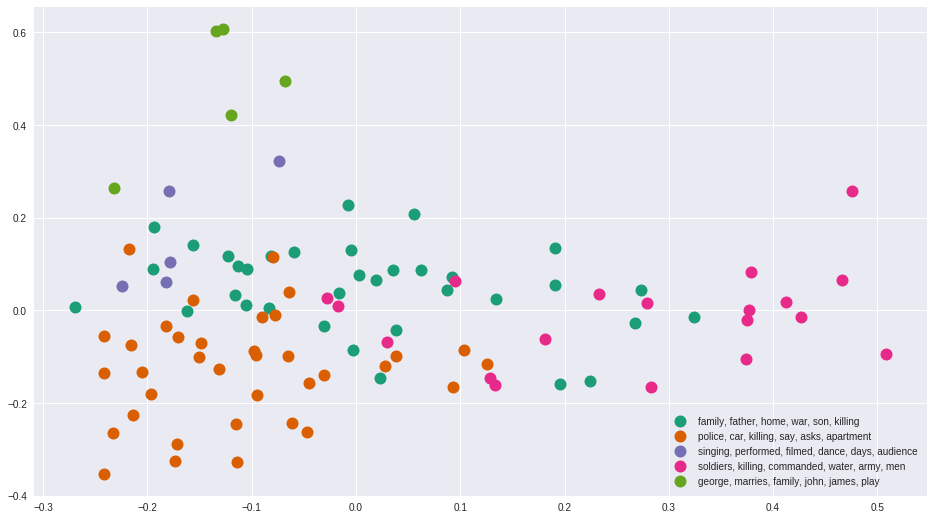

In [59]:
#create data frame with PCA cluster results
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 
groups = df.groupby(clusters)

# set up plot
fig, ax = plt.subplots(figsize=(16, 9))
#Set color for each cluster/group
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')

ax.legend(numpoints=1,loc=4)  #show legend with only 1 point, position is right bottom.

plt.show() #show the plot

# Topic Modeling - Latent Dirichlet Allocation

In [0]:
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=5, learning_method = 'online')

In [0]:
tfidf_matrix_lda = (tfidf_matrix * 100)
tfidf_matrix_lda = tfidf_matrix_lda.astype(int)

In [62]:
lda.fit(tfidf_matrix_lda)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=5, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [63]:
topic_word = lda.components_
print(topic_word.shape)

(5, 538)


In [0]:
n_top_words = 7
topic_keywords_list = []
for i, topic_dist in enumerate(topic_word):
    #Here we select top(n_top_words-1)
    lda_topic_words = np.array(tf_selected_words)[np.argsort(topic_dist)][:-n_top_words:-1] 
    for j in range(len(lda_topic_words)):
        lda_topic_words[j] = vocab_frame_dict[lda_topic_words[j]]
    topic_keywords_list.append(lda_topic_words.tolist())

In [65]:
doc_topic = lda.transform(tfidf_matrix_lda)
print (doc_topic.shape)

(100, 5)


In [66]:
topic_doc_dict = {}
print ("<Document clustering result by LDA>")
for i in range(len(doc_topic)):
    topicID = doc_topic[i].argmax()
    if topicID not in topic_doc_dict:
        topic_doc_dict[topicID] = [titles[i]]
    else:
        topic_doc_dict[topicID].append(titles[i])
for i in topic_doc_dict:
    print ("Cluster " + str(i) + " words: " + ", ".join(topic_keywords_list[i]))
    print ("Cluster " + str(i) + " titles (" + str(len(topic_doc_dict[i])) + " movies): ")
    print (', '.join(topic_doc_dict[i]))
    print ()

<Document clustering result by LDA>
Cluster 0 words: father, car, brother, killing, train, police
Cluster 0 titles (16 movies): 
The Godfather, One Flew Over the Cuckoo's Nest, The Godfather: Part II, The Sound of Music, The Silence of the Lambs, Some Like It Hot, 12 Angry Men, Amadeus, Unforgiven, High Noon, The King's Speech, Rain Man, Pulp Fiction, Stagecoach, Rebel Without a Cause, North by Northwest

Cluster 1 words: police, apartment, love, car, john, friend
Cluster 1 titles (32 movies): 
The Shawshank Redemption, Casablanca, The Wizard of Oz, Psycho, Sunset Blvd., On the Waterfront, Forrest Gump, West Side Story, E.T. the Extra-Terrestrial, Singin' in the Rain, Gandhi, Ben-Hur, The Good, the Bad and the Ugly, The Apartment, The Pianist, Goodfellas, The Deer Hunter, The French Connection, It Happened One Night, Midnight Cowboy, Good Will Hunting, Fargo, The Grapes of Wrath, The Green Mile, Close Encounters of the Third Kind, American Graffiti, The Maltese Falcon, Taxi Driver, Wut

In [69]:
doc_topic

array([[7.64743037e-01, 1.41214636e-02, 3.18035215e-02, 3.94661734e-02,
        1.49865805e-01],
       [1.93833759e-01, 8.05444705e-01, 2.40460245e-04, 2.40650472e-04,
        2.40425760e-04],
       [2.17893836e-04, 2.15777942e-01, 2.17403031e-04, 6.21214911e-01,
        1.62571850e-01],
       [2.47459306e-04, 2.46843877e-04, 9.99011239e-01, 2.47368057e-04,
        2.47090086e-04],
       [1.68135737e-01, 5.34061459e-01, 2.22246059e-04, 2.97357640e-01,
        2.22918176e-04],
       [9.32977598e-01, 2.11651650e-04, 2.12006387e-04, 6.63874775e-02,
        2.11266256e-04],
       [7.36883203e-02, 2.44838636e-01, 1.81662102e-02, 3.01312065e-01,
        3.61994769e-01],
       [2.06457439e-04, 2.06930855e-04, 3.09502461e-01, 2.06321167e-04,
        6.89877830e-01],
       [2.29096369e-04, 9.61437960e-01, 2.29707261e-04, 3.78742823e-02,
        2.28953762e-04],
       [2.68404512e-04, 8.39692522e-04, 1.10556851e-01, 8.88066128e-01,
        2.68924537e-04],
       [2.36776906e-04, 2.3706